In [1]:
import numpy as np
import nibabel as nib

def read_im_gt(img_path, gt_path, organ_label = None, RAS = False):
    img, gt = nib.load(img_path), nib.load(gt_path)
    img_ras, gt_ras = img, gt  # Initialize variables to hold potentially reoriented images

    # Check if gt, image are already in RAS+ 
    if nib.aff2axcodes(img.affine) != ('R', 'A', 'S'):
        img_ras = nib.as_closest_canonical(img)

    if nib.aff2axcodes(gt.affine) != ('R', 'A', 'S'):
        gt_ras = nib.as_closest_canonical(gt)

    img_data = img_ras.get_fdata().astype(np.float32)
    gt_data = gt_ras.get_fdata().astype(int)

    # Ensure organ is binary
    if organ_label is None:
        flat_data = gt_data.ravel()
        if not np.all( (flat_data == 0) | (flat_data == 1)):
            raise ValueError('Ground truth is not binary and no foreground label to subset to is specified')
        
    else:
        gt_data = (gt_data == organ_label).astype(int)

    if not RAS:
        img_data, gt_data = img_data.transpose(2,1,0), gt_data.transpose(2,1,0) # change from RAS to row-major ie xyz to zyx
    
    return(img_data, gt_data)

In [5]:
from torchio import Resample
from nnunetv2.preprocessing.resampling.default_resampling import resample_data_or_seg_to_spacing


In [2]:
from utils.modelUtils import load_sammed3d
from classes.SAMMed3DClass import SAMMed3DInferer, SAMMed3DWrapper

import utils.promptUtils as prUt
import utils.analysisUtils as anUt
#from utils.imageUtils import read_im_gt

def repixel_value(arr):
    min_val = arr.min()
    max_val = arr.max()
    new_arr = (arr - min_val) / (max_val - min_val + 1e-10) * 255.
    return(new_arr)



# Obtain model, image, gt
device = 'cuda'
checkpoint_path = '/home/t722s/Desktop/UniversalModels/TrainedModels/sam_med3d.pth'
# checkpoint_path = '/home/t722s/Desktop/UniversalModels/TrainedModels/sam_med3d_turbo.pth' # Turbo

sammed3d_model = load_sammed3d(checkpoint_path, device)
SAMMed3D_wrapper = SAMMed3DWrapper(sammed3d_model, device)
inferer = SAMMed3DInferer(SAMMed3D_wrapper)

# img_path = '/home/t722s/Desktop/Datasets/BratsMini/imagesTs/BraTS2021_01646.nii.gz'
# gt_path = '/home/t722s/Desktop/Datasets/BratsMini/labelsTs/BraTS2021_01646.nii.gz'
# img, gt = read_im_gt(img_path, gt_path, RAS = True)

img_path = '/home/t722s/Desktop/Datasets/amosForUniversegTest/imagesTs/amos_0001.nii.gz'
gt_path = '/home/t722s/Desktop/Datasets/amosForUniversegTest/labelsTs/amos_0001.nii.gz'
img, gt = read_im_gt(img_path, gt_path, 2, RAS = True)

# img_path = '/home/t722s/Desktop/Datasets/Dataset350_AbdomenAtlasJHU_sub/imagesTr/BDMAP_00000001_0000.nii.gz'
# gt_path = '/home/t722s/Desktop/Datasets/Dataset350_AbdomenAtlasJHU_sub/labelsTr/BDMAP_00000001.nii.gz'
# CT = True
# img, gt = read_im_gt(img_path, gt_path, 1, RAS = True)
# if CT:
#     img = repixel_value(img)



/home/t722s/anaconda3/envs/universalModels/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/t722s/anaconda3/envs/universalModels/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [8]:
# Experiment: n randomly selected fg points
n = 5
seed = 11121

pts_prompt = prUt.get_pos_clicks3D(gt, n, seed)
segmentation = inferer.predict(img, pts_prompt)
anUt.compute_dice(segmentation, gt)

0.40036571760896733

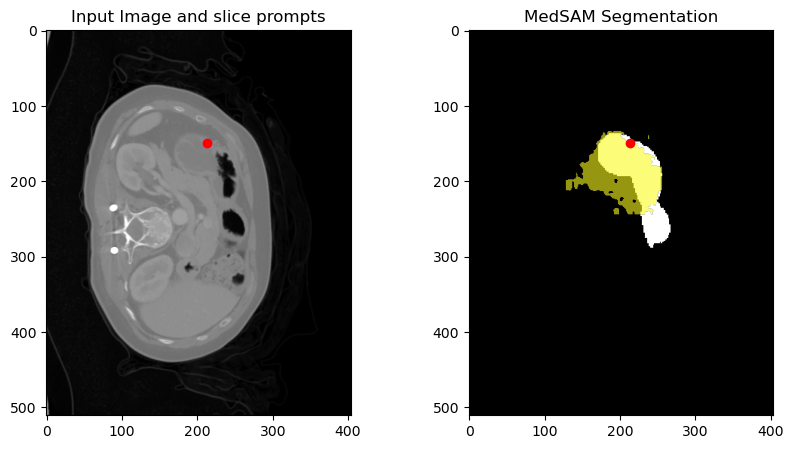

0.6278957860727298

In [11]:
slice_idx = 147
anUt.show_seg(slice_idx, img, gt, segmentation, pts_prompt = pts_prompt)